In [1]:
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

In [6]:
save_dir = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses")

# Load single experiment

In [7]:
data_dir = Path(r"E:\GAT1_EEG_pilot")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,genotype,mouse,sex,exp_folder,sweep_states,bad_chs,notes
0,GAT1-KO,mouse645606,M,signal_test_2022-11-18_14-49-19,awake,none,NaN
1,GAT1-KO,mouse645606,M,spontEEG1_2022-11-22_17-12-47,awake,none,NaN
2,GAT1-KO,mouse645606,M,EEGNPXspont_estim_2022-12-20_12-26-39,awake,none,NaN
3,GAT1-KO,mouse644565,F,signal_test_2022-11-30_15-41-47,awake,none,NaN
4,GAT1-KO,mouse644565,F,spontEEG1_2022-12-07_16-07-14,awake,none,NaN


In [8]:
choose_sub = 8
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

Experiment type: sensory stimulation


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\GAT1-KO_analyses', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

visual


Get coords for stim electrode

In [10]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
    print(stim_elec_data)
else:
    print('Stim electrode location file not found.')

Stim electrode location file not found.


## Load other data

### Load stim log

In [11]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    # print(stim_log.head())
else:
    stim_log = None
    print('No stim log found.')

In [12]:
stim_log.head()

,stim_type,parameter,onset,offset,duration,sweep
0,circle,white,1282.95437,1283.20360,0.24923,0
1,circle,white,1287.30797,1287.55722,0.24925,0
2,circle,white,1292.76256,1293.01179,0.24923,0
3,circle,white,1297.38306,1297.63230,0.24924,0
4,circle,white,1301.78675,1302.03599,0.24924,0


### Load SWDs

In [13]:
auto_annot_file = os.path.join(exp.data_folder, r'autoSWDs_v1.pkl')
if os.path.exists(auto_annot_file):
    print('Whoope there it is')
    autoSWD_df = pd.read_pickle(auto_annot_file)
else:
    print('Oops, you forgot to run the auto annotation notebook')
    autoSWD_df = None

Whoope there it is


In [14]:
autoSWD_df.head()

,onset,offset,duration,spike_count,SWD_spike_times
0,57.798179,58.666982,0.868803,5,"[57.798179324282415, 58.07098029335779, 58.229..."
1,59.698986,62.501396,2.802410,20,"[59.69898607654946, 59.82098650993359, 59.9489..."
2,63.016198,63.905401,0.889203,7,"[63.01619786033535, 63.26899875836412, 63.3837..."
3,65.432206,66.683411,1.251204,10,"[65.4322064427623, 65.56420691166971, 65.70820..."
4,70.006223,72.489832,2.483609,17,"[70.00622269111531, 70.12702312023666, 70.3706..."


In [15]:
print(len(autoSWD_df))

1015


### Load pupil diameter, if it exists

In [16]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilR = pupildf.Largest_Radius.values
    ## smooth pupil radius, then normalize ##
    sm_pupil = np.zeros_like(pupilR)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilR)-k-1):
        sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilR[:k]
    sm_pupil[-k-1:] = pupilR[-k-1:]
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

0% of frames do not have good pupil measurements


In [17]:
np.mean(pupildf.Eye_Diameter.values)

329.5645042241892

### Load running

In [18]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
raw_running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    print('Loading saved speed file...')
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)
else:
    print('Loading and saving running speed...')
    speed, raw_speed, speedts = exp.load_running()
    np.save(running_file, speed, allow_pickle=False)
    np.save(raw_running_file, raw_speed, allow_pickle=False)
    np.save(running_ts_file, speedts, allow_pickle=False)

Loading saved speed file...


Original plot

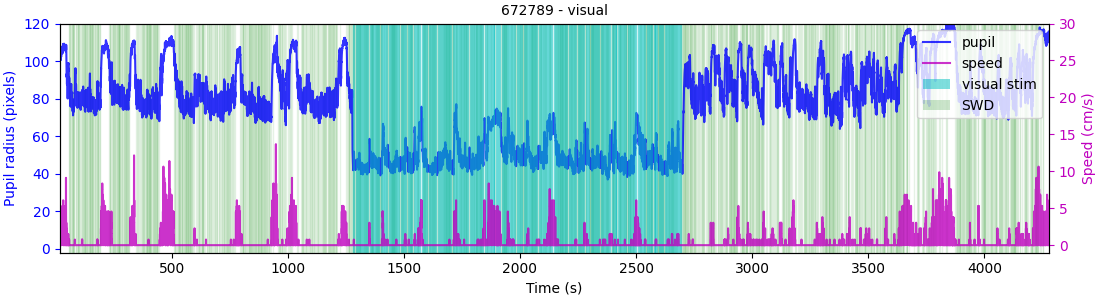

In [19]:
fig, ax = plt.subplots(figsize=(11,3), constrained_layout=True)
legenditems = []
## Pupil ##
pup, = ax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
legenditems.append(pup)
ax.set_xlim([pupilts[0], pupilts[-1]])
ax.set_ylim([-2, 120])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil radius (pixels)', color='b')
ax.tick_params(axis='y', colors='b')

## Running ##
runax = ax.twinx()
run, = runax.plot(speedts, speed, color='m', alpha=0.8, label='speed')
legenditems.append(run)
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-1, 30])

## Add stim events ##
if stim_log is not None:
    for stype in np.unique(stim_log.stim_type.values):
        if stype == 'circle':
            evcol = 'c'
            evlabel = 'visual stim'
        elif stype == 'biphasic':
            evcol = 'r'
            evlabel = 'elec stim'
        stypeevents = stim_log[stim_log['stim_type'] == stype].onset.values
        for eventi_on in stypeevents:
            ax.axvline(eventi_on, color=evcol, linewidth=1.0, alpha=0.5)
        legenditems.append(mpatches.Rectangle((0, 0), 1, 1, fc=evcol, alpha=0.5, label=evlabel))

## Add SWD events ##
if autoSWD_df is not None:
    for ii, SWDi in autoSWD_df.iterrows():
        ax.axvspan(SWDi.onset, SWDi.offset, color='g', alpha=0.1)
    legenditems.append(mpatches.Rectangle((0, 0), 1, 1, fc='g', alpha=0.2, label='SWD'))

## Set title and legend ##
ax.set_title('{} - {}'.format(exp.mouse, exp_tag))
ax.legend(handles = legenditems, loc='upper right')

# Load all subjects to loop through

In [28]:
all_subexp.head()

,genotype,mouse,sex,exp_folder,sweep_states,bad_chs,notes
0,GAT1-KO,mouse645606,M,signal_test_2022-11-18_14-49-19,awake,none,NaN
1,GAT1-KO,mouse645606,M,spontEEG1_2022-11-22_17-12-47,awake,none,NaN
2,GAT1-KO,mouse645606,M,EEGNPXspont_estim_2022-12-20_12-26-39,awake,none,NaN
3,GAT1-KO,mouse644565,F,signal_test_2022-11-30_15-41-47,awake,none,NaN
4,GAT1-KO,mouse644565,F,spontEEG1_2022-12-07_16-07-14,awake,none,NaN


Loop through each subject to make the plot

Experiment type: sensory stimulation
mouse645606: signal_test
 No stim electrode .json file.
 0% of frames do not have good pupil measurements
 Loading saved speed file...

No *stim* files were found.
Experiment type: spontaneous
mouse645606: spontEEG1
 No stim electrode .json file.
 No stim log found.
 0% of frames do not have good pupil measurements
 Loading saved speed file...

Experiment type: electrical stimulation
mouse645606: EEGNPXspont_estim
 0% of frames do not have good pupil measurements
 Loading saved speed file...

Experiment type: sensory stimulation
mouse644565: signal_test
 No stim electrode .json file.
 0% of frames do not have good pupil measurements
 Loading saved speed file...

No *stim* files were found.
Experiment type: spontaneous
mouse644565: spontEEG1
 No stim electrode .json file.
 No stim log found.
 0% of frames do not have good pupil measurements
 Loading saved speed file...

Experiment type: electrical stimulation
mouse644565: EEGNPXspont_estim
 0% of fra

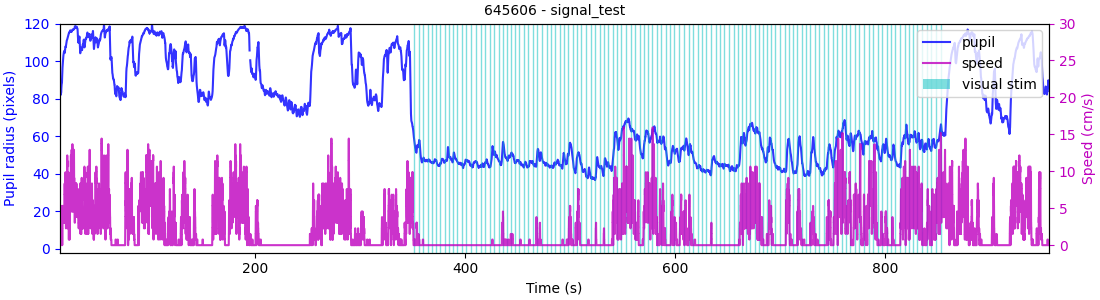

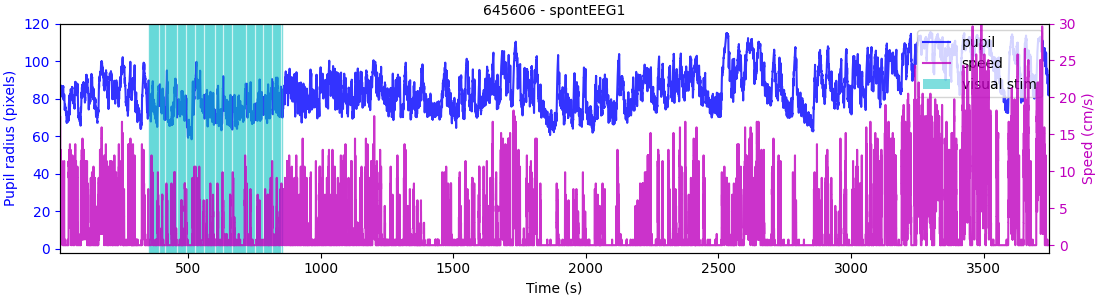

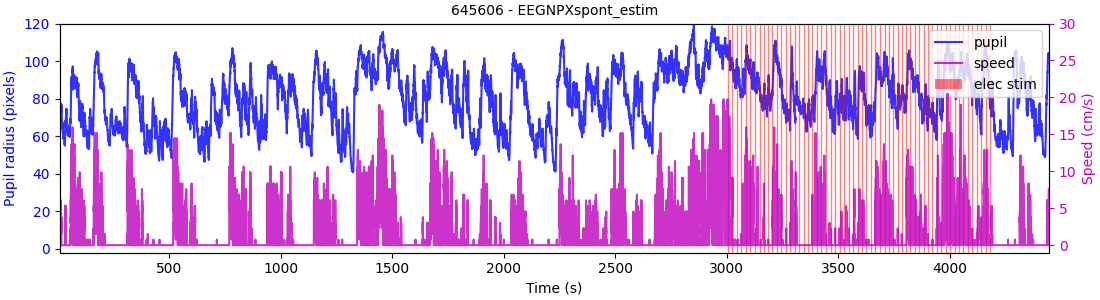

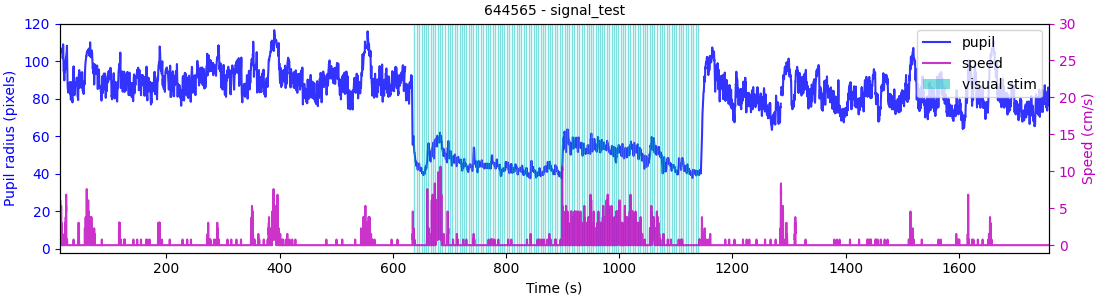

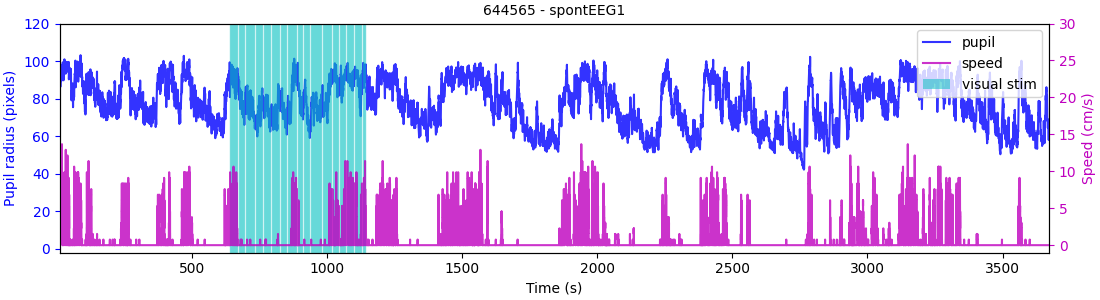

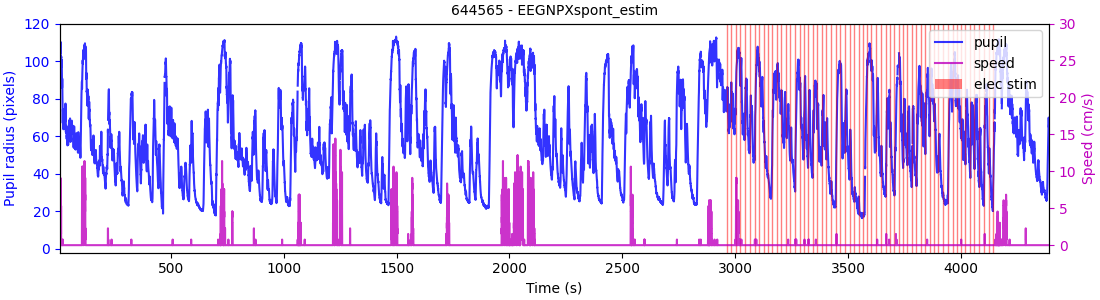

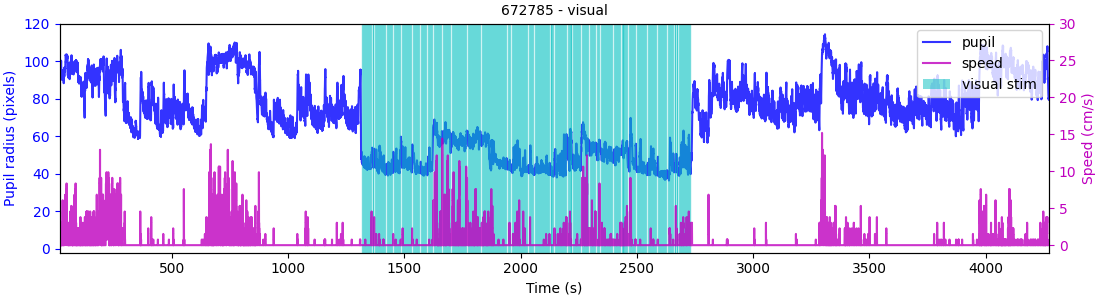

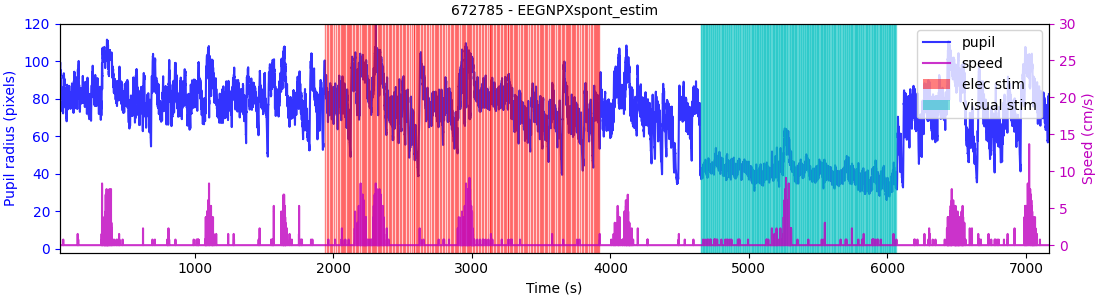

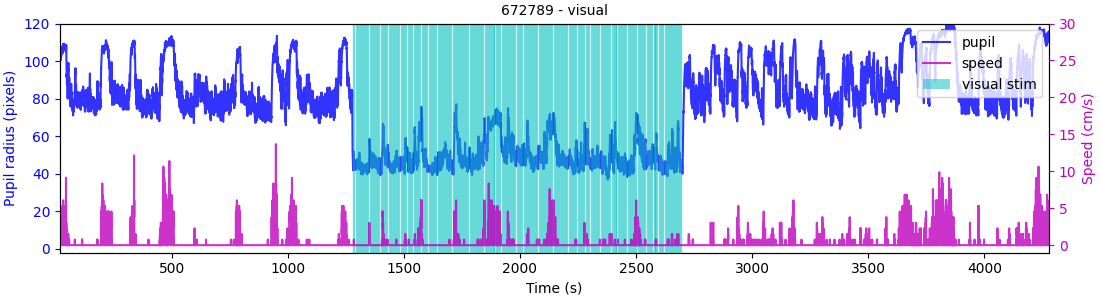

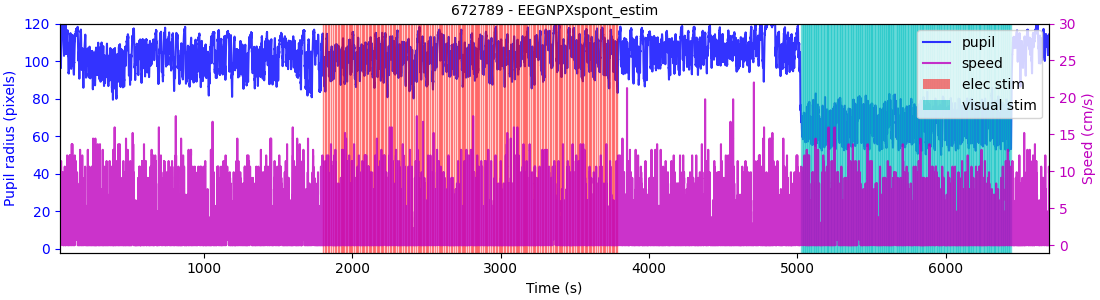

In [43]:
for indi, exprow in all_subexp.iterrows():
    data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
    print('{}: {}'.format(exprow.mouse, exp_tag))

    ## Get stim elec location ##
    stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
    if os.path.exists(stim_elec_file):
        with open(stim_elec_file) as elec_file:
            stim_elec_data = json.load(elec_file)
    else:
        print(' No stim electrode .json file.')

    ## Load the stim log ##
    if exp.stimulus_log_file:
        stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
        # print(stim_log.head())
    else:
        print(' No stim log found.')
    
    ## Load the pupil file ##
    if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
        pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
        pupildf = pd.read_csv(pupil_file)
        pupilts = pupildf.sync_time.values
        pupilR = pupildf.Largest_Radius.values
        ## smooth pupil radius ##
        sm_pupil = np.zeros_like(pupilR)
        k = 5 # filter window is actually k*2+1
        for i in range(k, len(pupilR)-k-1):
            sm_pupil[i] = np.mean(pupilR[i-k:i+k]) # each point is the average of k surrounding points
        sm_pupil[:k] = pupilR[:k]
        sm_pupil[-k-1:] = pupilR[-k-1:]
        print(' {:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilR)) / len(pupilR)) * 100)))
    else:
        print(' No local Pupileye*.csv file. Check server.\n')
        continue

    ## Load the running signal ##
    running_file = os.path.join(exp.data_folder, 'running_signal.npy')
    raw_running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
    running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
    if os.path.exists(running_file) and os.path.exists(running_ts_file):
        print(' Loading saved speed file...')
        speed = np.load(running_file)
        speedts = np.load(running_ts_file)
    else:
        print(' Loading and saving running speed...')
        speed, raw_speed, speedts = exp.load_running()
        np.save(running_file, speed, allow_pickle=False)
        np.save(raw_running_file, raw_speed, allow_pickle=False)
        np.save(running_ts_file, speedts, allow_pickle=False)

    ## Create the summary plot ##
    fig, ax = plt.subplots(figsize=(11,3), constrained_layout=True)
    legenditems = []
    ## Pupil ##
    pup, = ax.plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
    legenditems.append(pup)
    ax.set_xlim([pupilts[0], pupilts[-1]])
    ax.set_ylim([-2, 120])
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Pupil radius (pixels)', color='b')
    ax.tick_params(axis='y', colors='b')
    
    ## Running ##
    runax = ax.twinx()
    run, = runax.plot(speedts, speed, color='m', alpha=0.8, label='speed')
    legenditems.append(run)
    runax.set_ylabel('Speed (cm/s)', color='m')
    runax.tick_params(axis='y', colors='m')
    runax.set_ylim([-1, 30])
    
    ## Add stim events ##
    if stim_log is not None:
        stiml = []
        for stype in np.unique(stim_log.stim_type.values):
            if stype == 'circle':
                evcol = 'c'
                evlabel = 'visual stim'
            elif stype == 'biphasic':
                evcol = 'r'
                evlabel = 'elec stim'
            stypeevents = stim_log[stim_log['stim_type'] == stype].onset.values
            for eventi_on in stypeevents:
                ax.axvline(eventi_on, color=evcol, linewidth=1.0, alpha=0.5)
            legenditems.append(mpatches.Rectangle((0, 0), 1, 1, fc=evcol, alpha=0.5, label=evlabel))
    
    ## Set title and legend ##
    ax.set_title('{} - {}'.format(exp.mouse, exp_tag))
    ax.legend(handles = legenditems, loc='upper right')

    ## Save the figure ##
    fig_name = '{}{}_experimentsummary.png'.format(exp.mouse, exp_tag)
    fig.savefig(os.path.join(save_dir, fig_name), transparent=False) 

    print('')